# GAN Training Pitfalls on Engineering Design Problems

This notebook demonstrates different training configurations for Generative Adversarial Networks (GANs) on real engineering design problems from EngiBench. We'll use the `beams2d` problem to explore how varying the learning rate balance between generator and discriminator affects training dynamics and output quality.

We use the **cgan_2d** architecture (fully-connected layers) which is simpler and faster than CNN-based models.

## Experiments

We'll run three training configurations with different learning rate ratios:
1. **Discriminator Overpowers Generator**: Very low generator LR, very high discriminator LR
2. **Generator Overpowers Discriminator**: Very high generator LR, very low discriminator LR  
3. **Balanced Training**: Standard balanced learning rate configuration

Compare the training metrics and generated designs to understand the effects of each configuration.

## Troubleshooting

If you get a `ValueError` about tensor size mismatch:

```
ValueError: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1]))
```

**This means the kernel has an old cached version of the functions. Follow these steps:**

1. **Restart Kernel**: Go to `Kernel → Restart Kernel` in the menu
2. **Clear Output** (optional): Go to `Cell → All Output → Clear`  
3. **Run All Above**: Click on the first experiment cell, then `Cell → Run All Above`
4. **Run Validation Cell**: There's a validation cell right before the experiments - run it to confirm
5. **Run Your Experiment**: Now you can run the experiment cells

The notebook has been fixed - the issue is just that Jupyter caches function definitions in memory until you restart.

## Setup and Imports

## Important: Setup Instructions

**Before running experiments, you MUST run all cells in order:**

1. Run the "Setup and Imports" cell below
2. Run the "Load EngiBench Problem" cell
3. Run the "Model Architectures" cell  
4. Run the "Training History and Utilities" cell ← **Essential!**

If you get shape mismatch errors, restart the kernel and re-run all cells above before running experiments.

In [67]:
import os
import sys
import numpy as np
import torch as th
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from dataclasses import dataclass
from typing import NamedTuple

from engibench.utils.all_problems import BUILTIN_PROBLEMS

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

# Device selection
if th.backends.mps.is_available():
    device = th.device("mps")
elif th.cuda.is_available():
    device = th.device("cuda")
else:
    device = th.device("cpu")

print(f"Using device: {device}")

Using device: mps


## Load EngiBench Problem

We'll use the `beams2d` problem - a 2D structural design optimization problem where we need to generate optimal beam structures for different loading conditions and volume fraction constraints.

Problem: beams2d
Design shape: (50, 100)
Conditions: ['v', 'r', 'f', 'o']
Number of conditions: 4

Training samples: 3880


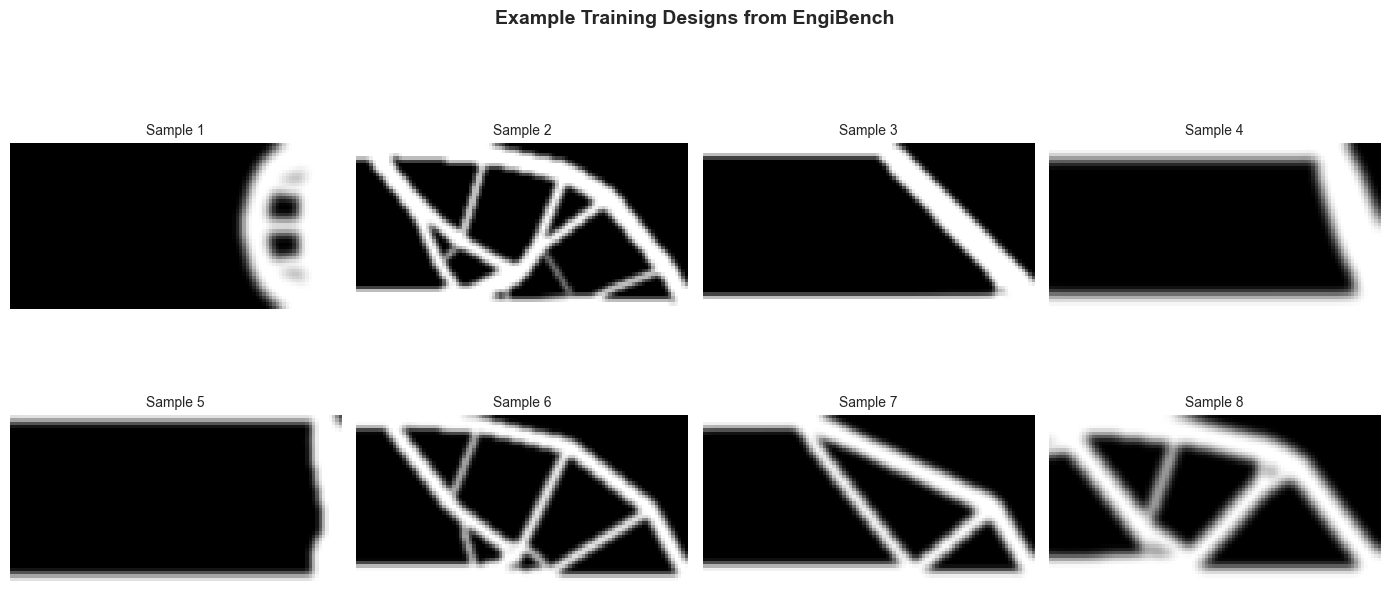

In [68]:
# Load problem
problem_id = "beams2d"
problem = BUILTIN_PROBLEMS[problem_id]()
problem.reset(seed=42)

design_shape = problem.design_space.shape
conditions = problem.conditions_keys
n_conds = len(conditions)

print(f"Problem: {problem_id}")
print(f"Design shape: {design_shape}")
print(f"Conditions: {[c[0] for c in conditions]}")
print(f"Number of conditions: {n_conds}")

# Load dataset
training_ds = problem.dataset.with_format("torch", device=device)["train"]
print(f"\nTraining samples: {len(training_ds)}")

# Show a few example designs
fig, axes = plt.subplots(2, 4, figsize=(14, 7))
axes = axes.flatten()
for i in range(8):
    design = training_ds["optimal_design"][i].cpu().numpy().reshape(design_shape)
    axes[i].imshow(design, cmap='gray')
    axes[i].set_title(f'Sample {i+1}', fontsize=10)
    axes[i].axis('off')
plt.suptitle('Example Training Designs from EngiBench', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Model Architectures

We'll use conditional GAN architectures from `cgan_2d` - simpler fully-connected networks that are faster to train and make failure modes more obvious.

In [69]:
class Generator(nn.Module):
    """Conditional GAN generator using fully-connected layers with better conditioning."""
    
    def __init__(self, latent_dim: int, n_conds: int, design_shape: tuple):
        super().__init__()
        self.design_shape = design_shape

        def block(in_feat: int, out_feat: int, normalize: bool = True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        # Separate paths for noise and conditions (like cGAN best practices)
        # This gives conditions more "weight" in the network
        self.noise_path = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
        )
        
        self.cond_path = nn.Sequential(
            nn.Linear(n_conds, 128),
            nn.LeakyReLU(0.2, inplace=True),
        )
        
        # Main generation path (after concatenation)
        self.model = nn.Sequential(
            *block(256, 512),  # 128 + 128 = 256
            *block(512, 1024),
            *block(1024, 2048),
            nn.Linear(2048, int(np.prod(design_shape))),
            nn.Tanh(),
        )

    def forward(self, z: th.Tensor, conds: th.Tensor) -> th.Tensor:
        """Generate design from noise and conditions.
        
        Args:
            z: Latent noise (B, latent_dim)
            conds: Conditions (B, n_conds)
            
        Returns:
            Generated design (B, *design_shape)
        """
        # Process noise and conditions separately
        z_feat = self.noise_path(z)
        c_feat = self.cond_path(conds)
        
        # Concatenate and generate
        gen_input = th.cat((z_feat, c_feat), -1)
        design = self.model(gen_input)
        return design.view(design.size(0), *self.design_shape)


class Discriminator(nn.Module):
    """Conditional GAN discriminator using fully-connected layers with better conditioning.
    
    Args:
        design_shape: Shape of input designs
        n_conds: Number of conditional features
        spectral_norm: If True, applies spectral normalization to constrain Lipschitz constant
    """
    
    def __init__(self, design_shape: tuple, n_conds: int, spectral_norm: bool = False):
        super().__init__()
        
        # Helper to optionally apply spectral normalization
        def maybe_spectral_norm(layer):
            if spectral_norm:
                return nn.utils.spectral_norm(layer)
            return layer
        
        # Separate paths for design and conditions
        self.design_path = nn.Sequential(
            maybe_spectral_norm(nn.Linear(int(np.prod(design_shape)), 512)),
            nn.LeakyReLU(0.2, inplace=True),
        )
        
        self.cond_path = nn.Sequential(
            nn.Linear(n_conds, 128),
            nn.LeakyReLU(0.2, inplace=True),
        )
        
        # Main discrimination path (after concatenation)
        self.model = nn.Sequential(
            maybe_spectral_norm(nn.Linear(640, 512)),  # 512 + 128 = 640
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            maybe_spectral_norm(nn.Linear(512, 256)),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            maybe_spectral_norm(nn.Linear(256, 1)),
            nn.Sigmoid(),
        )

    def forward(self, design: th.Tensor, conds: th.Tensor) -> th.Tensor:
        """Classify design as real or fake given conditions.
        
        Args:
            design: Input design (B, *design_shape)
            conds: Conditions (B, n_conds)
            
        Returns:
            Validity score (B, 1)
        """
        design_flat = design.view(design.size(0), -1)
        
        # Process design and conditions separately
        d_feat = self.design_path(design_flat)
        c_feat = self.cond_path(conds)
        
        # Concatenate and discriminate
        d_in = th.cat((d_feat, c_feat), -1)
        return self.model(d_in)

print("Model architectures defined.")

Model architectures defined.


## Training History and Utilities

In [71]:
class TrainingHistory(NamedTuple):
    """Store training metrics."""
    d_loss: list[float]
    g_loss: list[float]
    d_real_score: list[float]
    d_fake_score: list[float]
    diversity: list[float]
    snapshots: list[dict]


def compute_diversity(samples: th.Tensor) -> float:
    """Compute diversity of generated samples using pairwise distances."""
    samples_flat = samples.reshape(samples.size(0), -1)
    dists = th.cdist(samples_flat, samples_flat, p=2)
    n = samples.size(0)
    if n <= 1:
        return 0.0
    return dists.sum().item() / (n * (n - 1))


def train_cgan(problem_id: str, n_epochs: int, batch_size: int, latent_dim: int,
               lr_gen: float, lr_disc: float, seed: int = 42,
               spectral_norm: bool = False,
               snapshot_interval: int = 10, print_every: int = 20) -> tuple:
    """Train conditional GAN on EngiBench problem.
    
    Args:
        spectral_norm: Apply spectral normalization to discriminator (Lipschitz-1 constraint)
    """
    # Setup
    th.manual_seed(seed)
    np.random.seed(seed)
    th.backends.cudnn.deterministic = True
    
    # Load problem
    problem = BUILTIN_PROBLEMS[problem_id]()
    problem.reset(seed=seed)
    design_shape = problem.design_space.shape
    n_conds = len(problem.conditions_keys)
    
    # Prepare data
    training_ds = problem.dataset.with_format("torch", device=device)["train"]
    dataset = TensorDataset(
        training_ds["optimal_design"][:].flatten(1),
        *[training_ds[key][:] for key in problem.conditions_keys]
    )
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Initialize models
    generator = Generator(latent_dim, n_conds, design_shape).to(device)
    discriminator = Discriminator(design_shape, n_conds, spectral_norm=spectral_norm).to(device)
    
    # Loss and optimizers
    criterion = nn.BCELoss()
    opt_gen = optim.Adam(generator.parameters(), lr=lr_gen, betas=(0.5, 0.999))
    opt_disc = optim.Adam(discriminator.parameters(), lr=lr_disc, betas=(0.5, 0.999))
    
    # Training history
    history = TrainingHistory([], [], [], [], [], [])
    
    # Helper to save snapshot
    def save_snapshot(epoch: int):
        with th.no_grad():
            z = th.randn(64, latent_dim, device=device)
            conds_list = [training_ds[key][:] for key in problem.conditions_keys]
            conds = th.stack([c[th.randint(0, len(c), (64,))] for c in conds_list], dim=1)
            samples = generator(z, conds).cpu()
        
        state = {k: v.cpu().clone() for k, v in generator.state_dict().items()}
        history.snapshots.append({
            "epoch": epoch,
            "state_dict": state,
            "samples": samples[:16],
            "conditions": conds[:16].cpu()
        })
    
    if snapshot_interval > 0:
        save_snapshot(0)
    
    # Training loop
    for epoch in range(n_epochs):
        d_losses, g_losses, d_real_scores, d_fake_scores = [], [], [], []
        
        for data in dataloader:
            designs = data[0]
            conds = th.stack(data[1:], dim=1)
            
            batch_size_actual = designs.size(0)
            valid = th.ones(batch_size_actual, device=device)
            fake = th.zeros(batch_size_actual, device=device)
            
            # Train Discriminator
            opt_disc.zero_grad()
            z = th.randn(batch_size_actual, latent_dim, device=device)
            gen_designs = generator(z, conds)
            
            real_pred = discriminator(designs.view(batch_size_actual, *design_shape), conds).squeeze()
            fake_pred = discriminator(gen_designs.detach(), conds).squeeze()
            
            d_loss = (criterion(real_pred, valid) + criterion(fake_pred, fake)) / 2
            d_loss.backward()
            opt_disc.step()
            
            # Train Generator
            opt_gen.zero_grad()
            z = th.randn(batch_size_actual, latent_dim, device=device)
            gen_designs = generator(z, conds)
            gen_pred = discriminator(gen_designs, conds).squeeze()
            
            g_loss = criterion(gen_pred, valid)
            g_loss.backward()
            opt_gen.step()
            
            # Record metrics
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            d_real_scores.append(real_pred.mean().item())
            d_fake_scores.append(fake_pred.mean().item())
        
        # Compute diversity
        with th.no_grad():
            z_eval = th.randn(100, latent_dim, device=device)
            conds_eval = conds[:100] if len(conds) >= 100 else conds
            samples_eval = generator(z_eval[:len(conds_eval)], conds_eval)
            diversity = compute_diversity(samples_eval)
        
        # Epoch metrics
        history.d_loss.append(np.mean(d_losses))
        history.g_loss.append(np.mean(g_losses))
        history.d_real_score.append(np.mean(d_real_scores))
        history.d_fake_score.append(np.mean(d_fake_scores))
        history.diversity.append(diversity)
        
        if snapshot_interval > 0 and (epoch + 1) % snapshot_interval == 0:
            save_snapshot(epoch + 1)
        
        if (epoch + 1) % print_every == 0 or epoch == 0:
            print(f"Epoch {epoch+1:03d}/{n_epochs} | D loss: {history.d_loss[-1]:.4f} | "
                  f"G loss: {history.g_loss[-1]:.4f} | D(real): {history.d_real_score[-1]:.3f} | "
                  f"D(fake): {history.d_fake_score[-1]:.3f} | Diversity: {history.diversity[-1]:.2f}")
    
    return generator, discriminator, history


def plot_training_diagnostics(history: TrainingHistory, title_suffix: str = ""):
    """Plot training diagnostics - 2x2 grid."""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    epochs = np.arange(1, len(history.d_loss) + 1)
    
    # Training Losses
    ax = axes[0, 0]
    ax.plot(epochs, history.d_loss, label='Discriminator', linewidth=2.5, alpha=0.8, color='C0')
    ax.plot(epochs, history.g_loss, label='Generator', linewidth=2.5, alpha=0.8, color='C1')
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Loss', fontsize=12)
    ax.set_title('Training Losses', fontsize=13, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    
    # Discriminator Predictions
    ax = axes[0, 1]
    ax.plot(epochs, history.d_real_score, label='D(real)', linewidth=2.5, alpha=0.8, color='C2')
    ax.plot(epochs, history.d_fake_score, label='D(fake)', linewidth=2.5, alpha=0.8, color='C3')
    ax.axhline(y=0.5, color='k', linestyle='--', alpha=0.4, linewidth=1.5, label='Random (0.5)')
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Score', fontsize=12)
    ax.set_title('Discriminator Predictions', fontsize=13, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-0.05, 1.05)
    
    # Loss Ratio
    ax = axes[1, 0]
    loss_ratio = np.array(history.d_loss) / (np.array(history.g_loss) + 1e-8)
    ax.plot(epochs, loss_ratio, linewidth=2.5, alpha=0.8, color='purple')
    ax.axhline(y=1.0, color='k', linestyle='--', alpha=0.4, linewidth=1.5, label='Balanced (1.0)')
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('D_loss / G_loss', fontsize=12)
    ax.set_title('Loss Ratio', fontsize=13, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    
    # Diversity
    ax = axes[1, 1]
    ax.plot(epochs, history.diversity, linewidth=2.5, alpha=0.8, color='teal')
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Avg Pairwise Distance', fontsize=12)
    ax.set_title('Sample Diversity', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    plt.suptitle(f'Training Diagnostics{title_suffix}', fontsize=15, fontweight='bold')
    plt.tight_layout()
    plt.show()


def plot_generated_vs_real_designs(generator, latent_dim: int, n_conds: int, 
                                   design_shape: tuple[int, int], title_suffix: str = "",
                                   n_samples: int = 8):
    """Visualize generated designs next to real designs with same conditions."""
    generator.eval()
    
    # Load problem and dataset
    problem = BUILTIN_PROBLEMS[problem_id]()
    training_ds = problem.dataset.with_format("torch", device=device)["train"]
    conds_list = [training_ds[key][:] for key in problem.conditions_keys]
    
    # Create grid of diverse conditions
    n_per_dim = int(np.sqrt(n_samples))
    if n_conds == 2:
        c1_vals = th.linspace(conds_list[0].min(), conds_list[0].max(), n_per_dim, device=device)
        c2_vals = th.linspace(conds_list[1].min(), conds_list[1].max(), n_per_dim, device=device)
        c1_grid, c2_grid = th.meshgrid(c1_vals, c2_vals, indexing='ij')
        conds = th.stack([c1_grid.flatten(), c2_grid.flatten()], dim=1)[:n_samples]
    else:
        indices = th.linspace(0, len(conds_list[0]) - 1, n_samples, device=device).long()
        conds = th.stack([c[indices] for c in conds_list], dim=1)
    
    # Generate designs
    with th.no_grad():
        z = th.randn(len(conds), latent_dim, device=device)
        gen_designs = generator(z, conds).cpu().numpy()
    
    # Find closest real designs for same conditions
    # Stack all training conditions into a matrix (N_train, n_conds)
    all_train_conds = th.stack(conds_list, dim=1)
    
    real_designs = []
    for i in range(len(conds)):
        # Find training sample with closest conditions
        cond_dists = th.cdist(conds[i:i+1], all_train_conds)
        closest_idx = cond_dists.argmin().item()  # Convert 0-d tensor to Python int
        real_design = training_ds["optimal_design"][closest_idx].cpu().numpy().reshape(design_shape)
        real_designs.append(real_design)
    
    conds_np = conds.cpu().numpy()
    
    # Plot: each row shows [Real | Generated] for same conditions
    fig, axes = plt.subplots(n_samples, 2, figsize=(8, n_samples * 2))
    if n_samples == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(n_samples):
        # Real design
        axes[i, 0].imshow(real_designs[i], cmap='viridis', vmin=-1, vmax=1)
        axes[i, 0].axis('off')
        if i == 0:
            axes[i, 0].set_title('Real Design', fontsize=12, fontweight='bold')
        
        # Generated design
        axes[i, 1].imshow(gen_designs[i], cmap='viridis', vmin=-1, vmax=1)
        axes[i, 1].axis('off')
        if i == 0:
            axes[i, 1].set_title('Generated Design', fontsize=12, fontweight='bold')
        
        # Condition label on the left
        cond_str = ", ".join([f"{conds_np[i, j]:.2f}" for j in range(n_conds)])
        fig.text(0.02, 1 - (i + 0.5) / n_samples, f"C: [{cond_str}]", 
                va='center', fontsize=10, fontweight='bold')
    
    plt.suptitle(f'Real vs Generated Designs{title_suffix}', fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout(rect=[0.1, 0, 1, 0.99])
    plt.show()

print("Training utilities defined.")

Training utilities defined.


## Experiment 1: Discriminator Overpowers Generator

**Training Configuration:**
- `lr_gen = 1e-5` (very low)
- `lr_disc = 1e-3` (very high) 
- Discriminator learns 100x faster than generator


EXPERIMENT 1: Discriminator Overpowers Generator
Settings: lr_gen=1e-5, lr_disc=1e-3 (D is 100x faster)

Epoch 001/100 | D loss: 0.0172 | G loss: 8.3396 | D(real): 0.994 | D(fake): 0.020 | Diversity: 3.35
Epoch 020/100 | D loss: 50.0000 | G loss: 18.4689 | D(real): 0.000 | D(fake): 0.000 | Diversity: 30.67
Epoch 040/100 | D loss: 50.0000 | G loss: 20.1309 | D(real): 0.000 | D(fake): 0.000 | Diversity: 40.62
Epoch 060/100 | D loss: 50.0000 | G loss: 20.9852 | D(real): 0.000 | D(fake): 0.000 | Diversity: 31.07
Epoch 080/100 | D loss: 50.0000 | G loss: 22.6021 | D(real): 0.000 | D(fake): 0.000 | Diversity: 25.69
Epoch 100/100 | D loss: 50.0000 | G loss: 24.5403 | D(real): 0.000 | D(fake): 0.000 | Diversity: 27.28


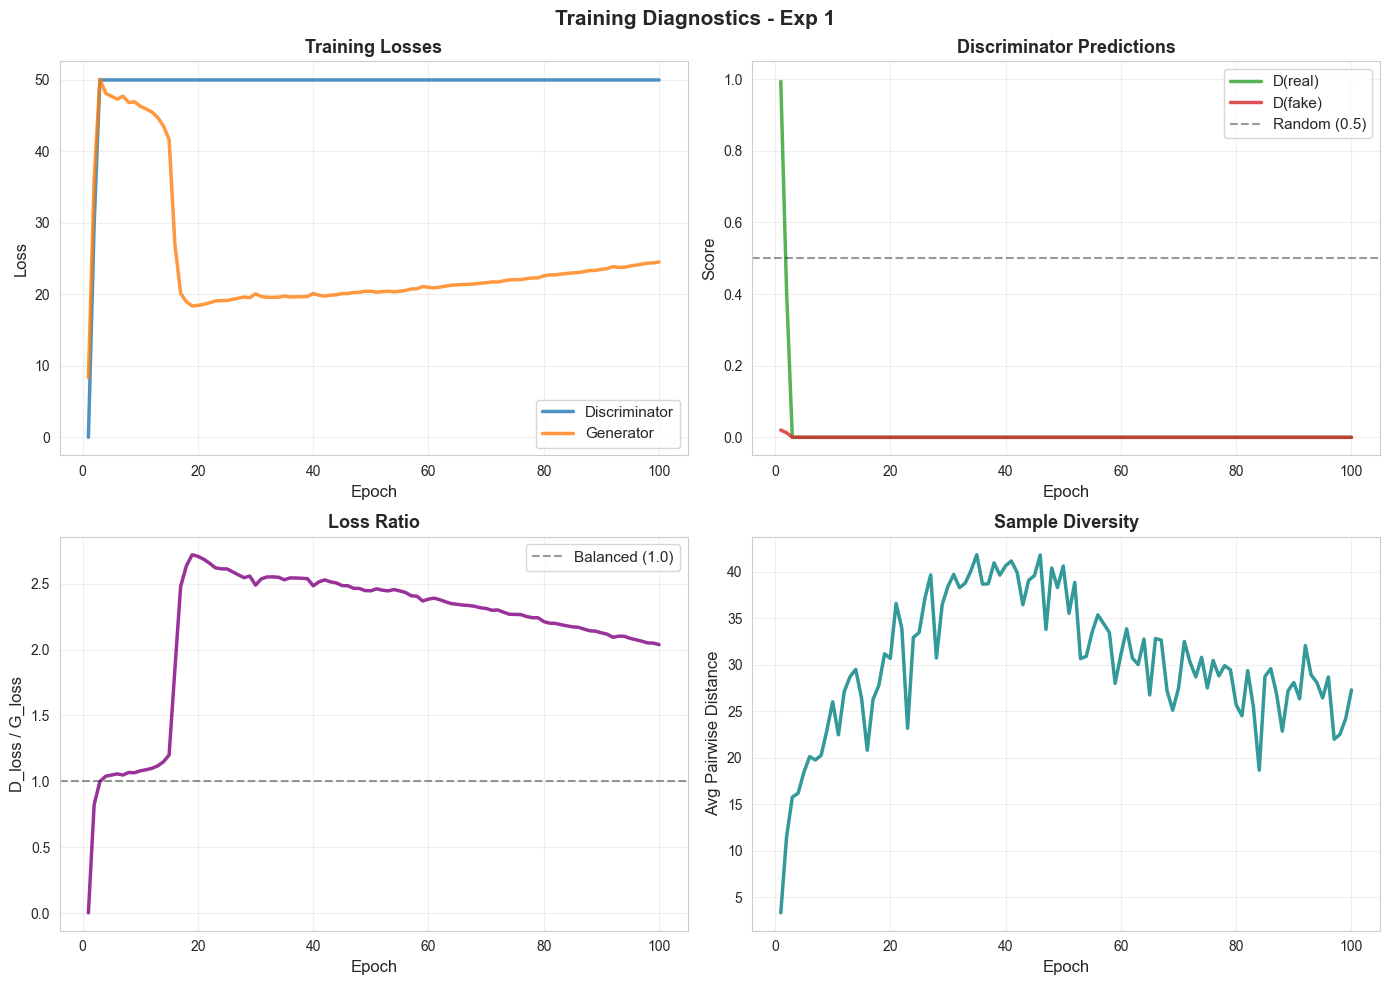

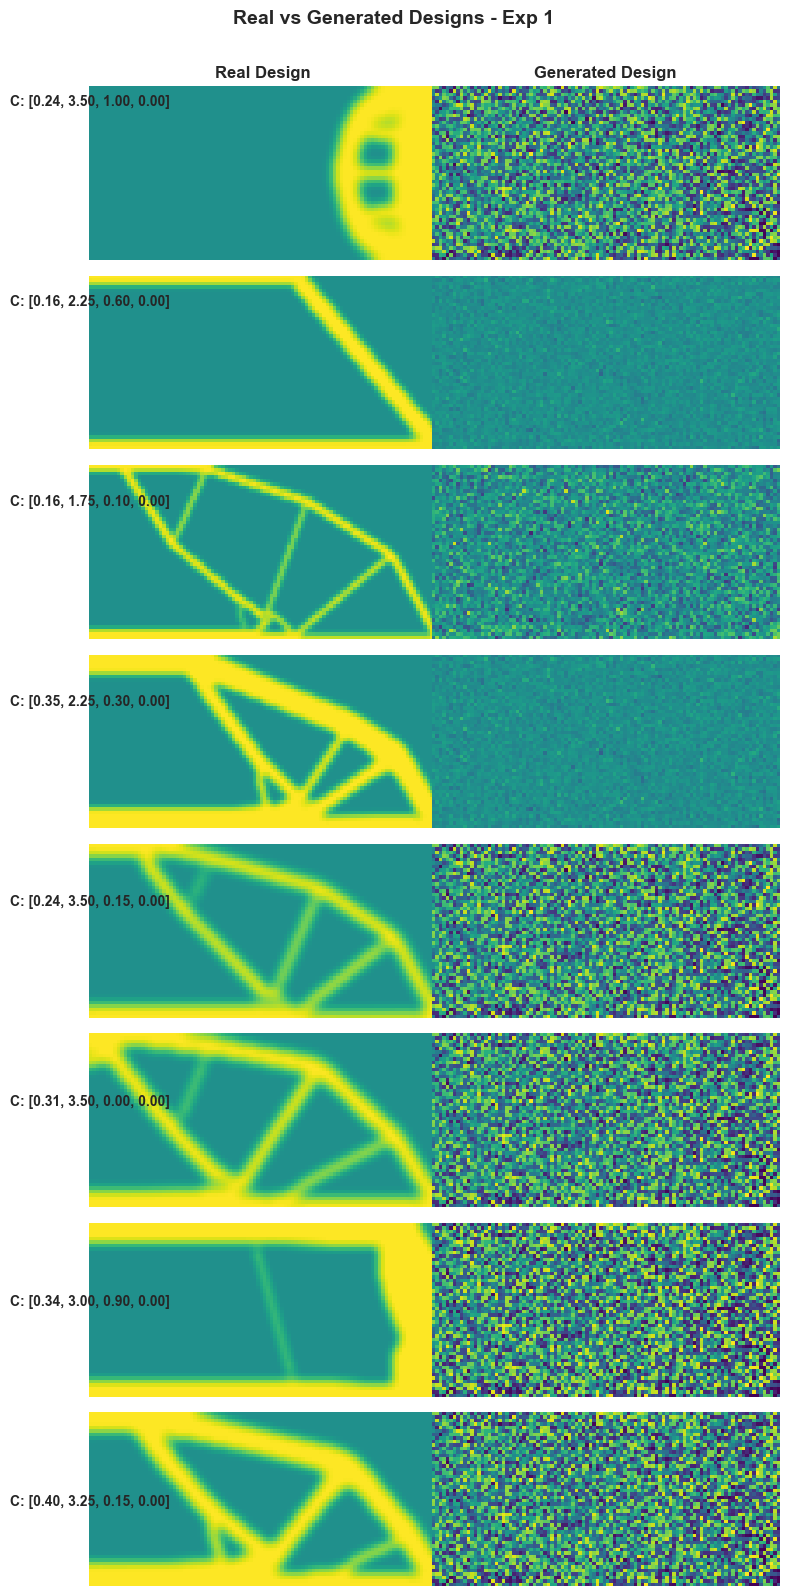

In [74]:
print("\n" + "="*80)
print("EXPERIMENT 1: Discriminator Overpowers Generator")
print("Settings: lr_gen=1e-5, lr_disc=1e-3 (D is 100x faster)")
print("="*80 + "\n")

latent_dim = 100
gen_exp1, disc_exp1, hist_exp1 = train_cgan(
    problem_id="beams2d",
    n_epochs=100,
    batch_size=32,
    latent_dim=latent_dim,
    lr_gen=1e-5,
    lr_disc=1e-3,
    seed=42,
    snapshot_interval=10,
    print_every=20,
    spectral_norm=False
)

plot_training_diagnostics(hist_exp1, " - Exp 1")
plot_generated_vs_real_designs(gen_exp1, latent_dim, n_conds, design_shape, " - Exp 1")

## Experiment 2: Generator Overpowers Discriminator

**Training Configuration:**
- `lr_gen = 5e-4` (very high)
- `lr_disc = 1e-5` (very low)
- Generator learns 50x faster than discriminator


EXPERIMENT 2: Generator Overpowers Discriminator
Settings: lr_gen=5e-4, lr_disc=1e-5 (G is 50x faster)

Epoch 001/100 | D loss: 0.7929 | G loss: 0.5039 | D(real): 0.545 | D(fake): 0.616 | Diversity: 38.22
Epoch 020/100 | D loss: 0.6941 | G loss: 0.6941 | D(real): 0.500 | D(fake): 0.500 | Diversity: 10.61
Epoch 040/100 | D loss: 0.6934 | G loss: 0.6941 | D(real): 0.500 | D(fake): 0.500 | Diversity: 15.16
Epoch 060/100 | D loss: 0.6924 | G loss: 0.6953 | D(real): 0.501 | D(fake): 0.500 | Diversity: 21.06
Epoch 080/100 | D loss: 0.6916 | G loss: 0.6972 | D(real): 0.501 | D(fake): 0.499 | Diversity: 24.90
Epoch 100/100 | D loss: 0.6909 | G loss: 0.6991 | D(real): 0.502 | D(fake): 0.499 | Diversity: 30.76


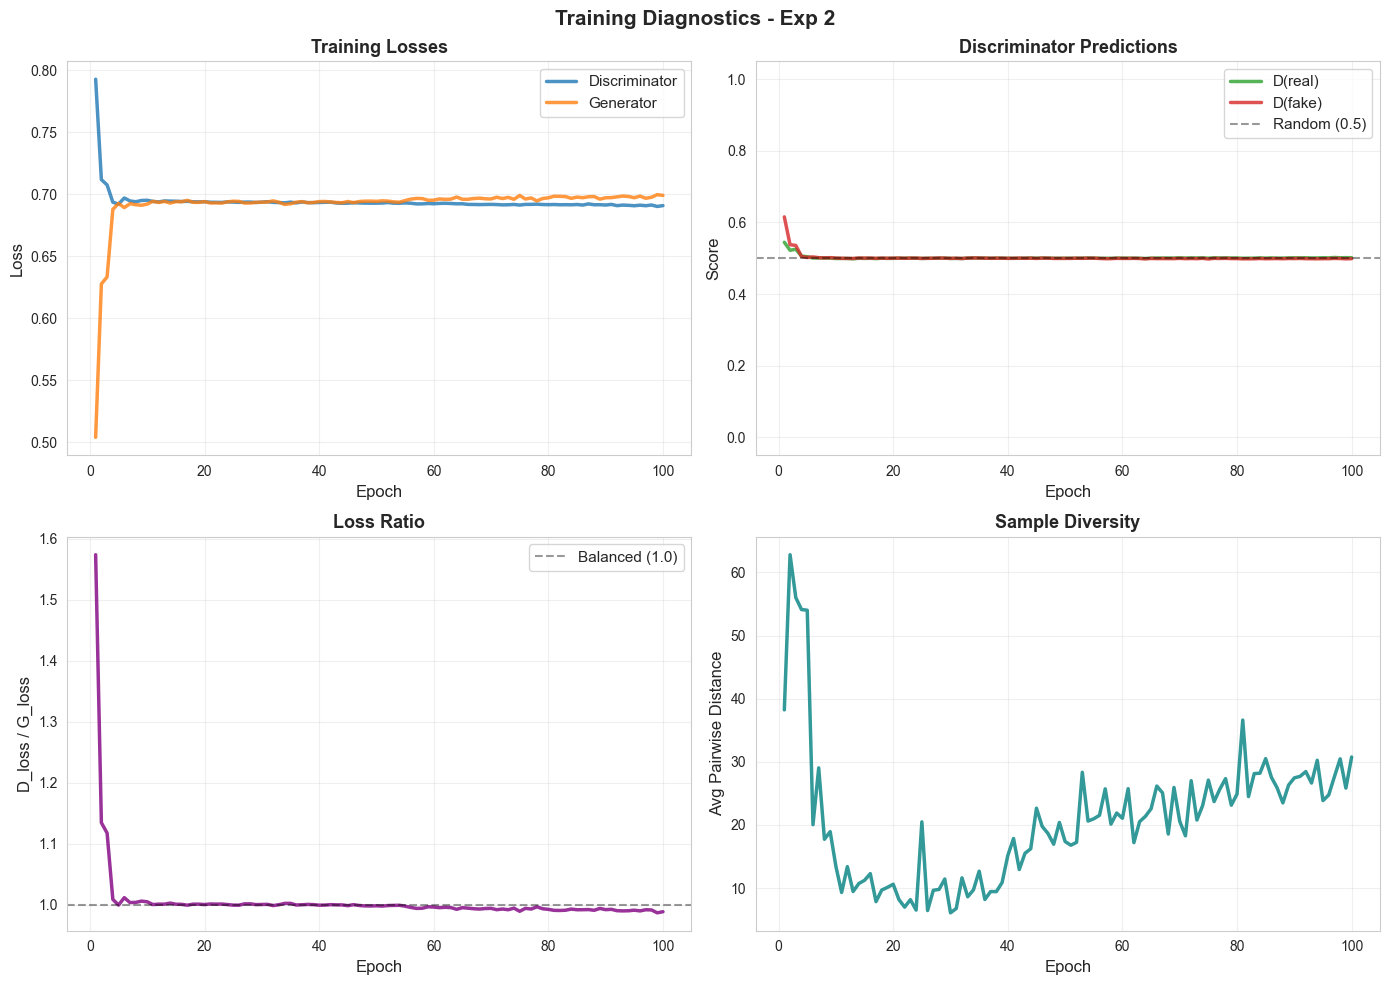

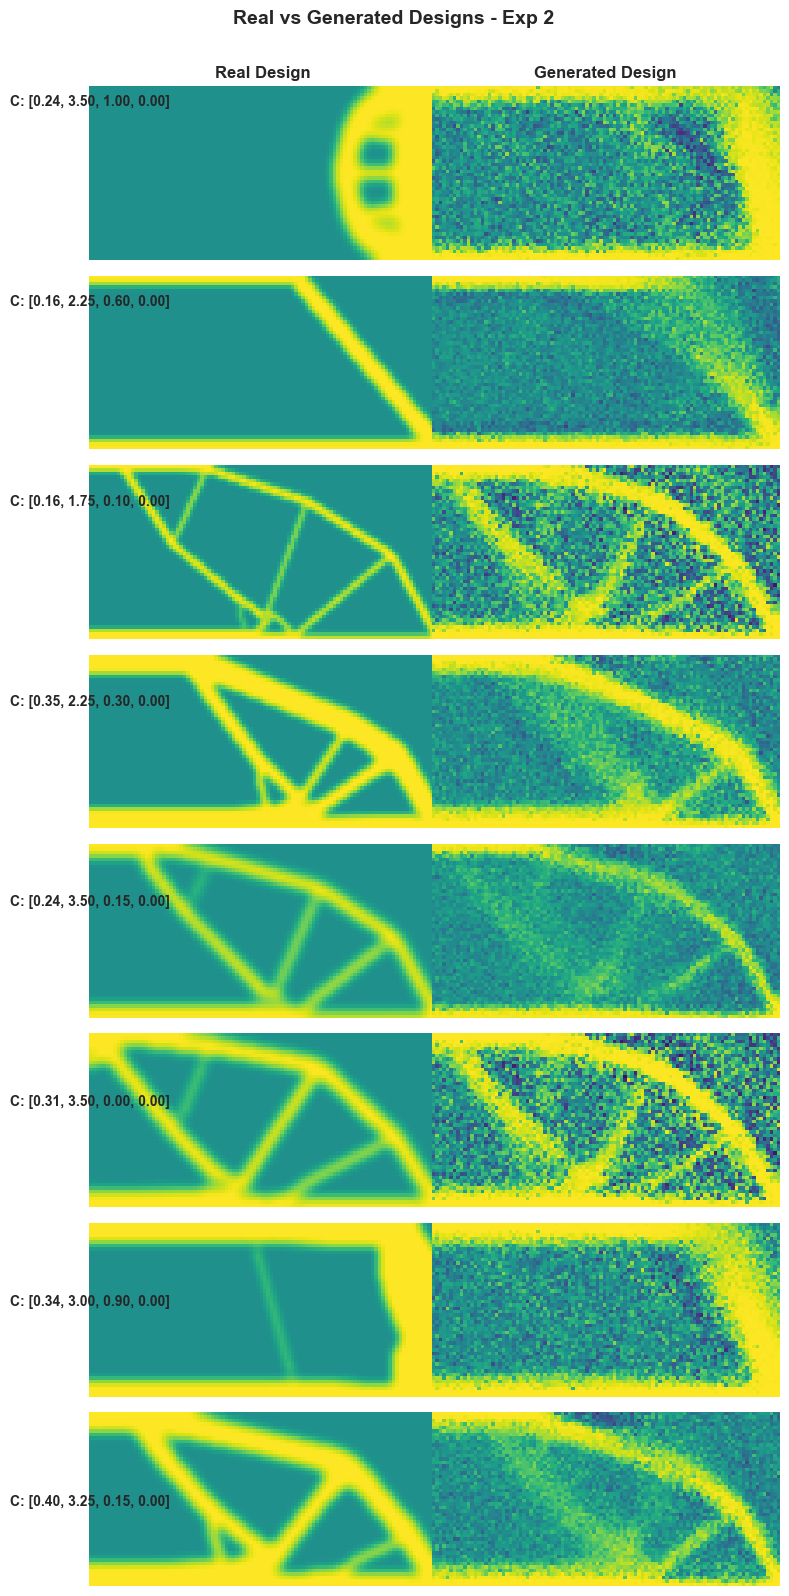

In [75]:
print("\n" + "="*80)
print("EXPERIMENT 2: Generator Overpowers Discriminator")
print("Settings: lr_gen=5e-4, lr_disc=1e-5 (G is 50x faster)")
print("="*80 + "\n")

latent_dim = 100

gen_exp2, disc_exp2, hist_exp2 = train_cgan(
    problem_id="beams2d",
    n_epochs=100,
    batch_size=32,
    latent_dim=latent_dim,
    lr_gen=5e-4,
    lr_disc=1e-5,
    seed=42,
    snapshot_interval=10,
    print_every=20,
    spectral_norm=False
)

plot_training_diagnostics(hist_exp2, " - Exp 2")
plot_generated_vs_real_designs(gen_exp2, latent_dim, n_conds, design_shape, " - Exp 2")

## Experiment 3: Balanced Training

**Training Configuration:**
- `lr_gen = 1e-4` (standard)
- `lr_disc = 4e-4` (standard, 4x ratio)
- Typical balanced learning rate configuration


EXPERIMENT 3: Balanced Training
Settings: lr_gen=1e-4, lr_disc=4e-4 (standard 1:4 ratio)

Epoch 001/100 | D loss: 0.5139 | G loss: 1.7920 | D(real): 0.700 | D(fake): 0.372 | Diversity: 12.66
Epoch 020/100 | D loss: 0.2931 | G loss: 2.7462 | D(real): 0.811 | D(fake): 0.192 | Diversity: 24.62
Epoch 040/100 | D loss: 0.2667 | G loss: 3.2074 | D(real): 0.832 | D(fake): 0.170 | Diversity: 25.18
Epoch 060/100 | D loss: 0.2082 | G loss: 4.1376 | D(real): 0.870 | D(fake): 0.131 | Diversity: 28.38
Epoch 080/100 | D loss: 0.2046 | G loss: 4.3083 | D(real): 0.872 | D(fake): 0.127 | Diversity: 28.07
Epoch 100/100 | D loss: 0.2002 | G loss: 4.3447 | D(real): 0.877 | D(fake): 0.126 | Diversity: 28.06


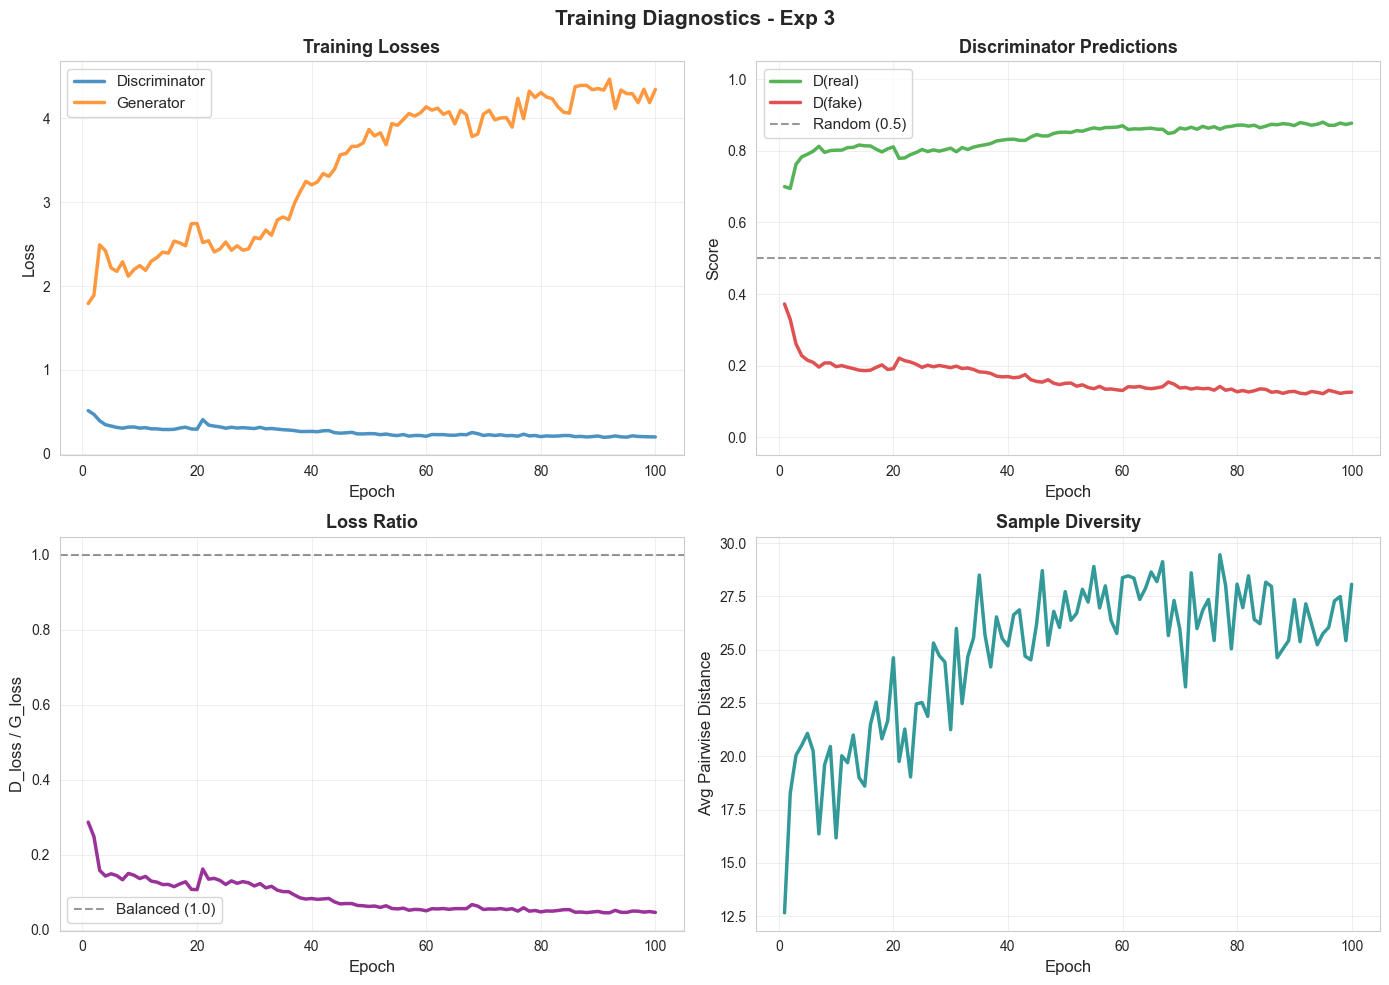

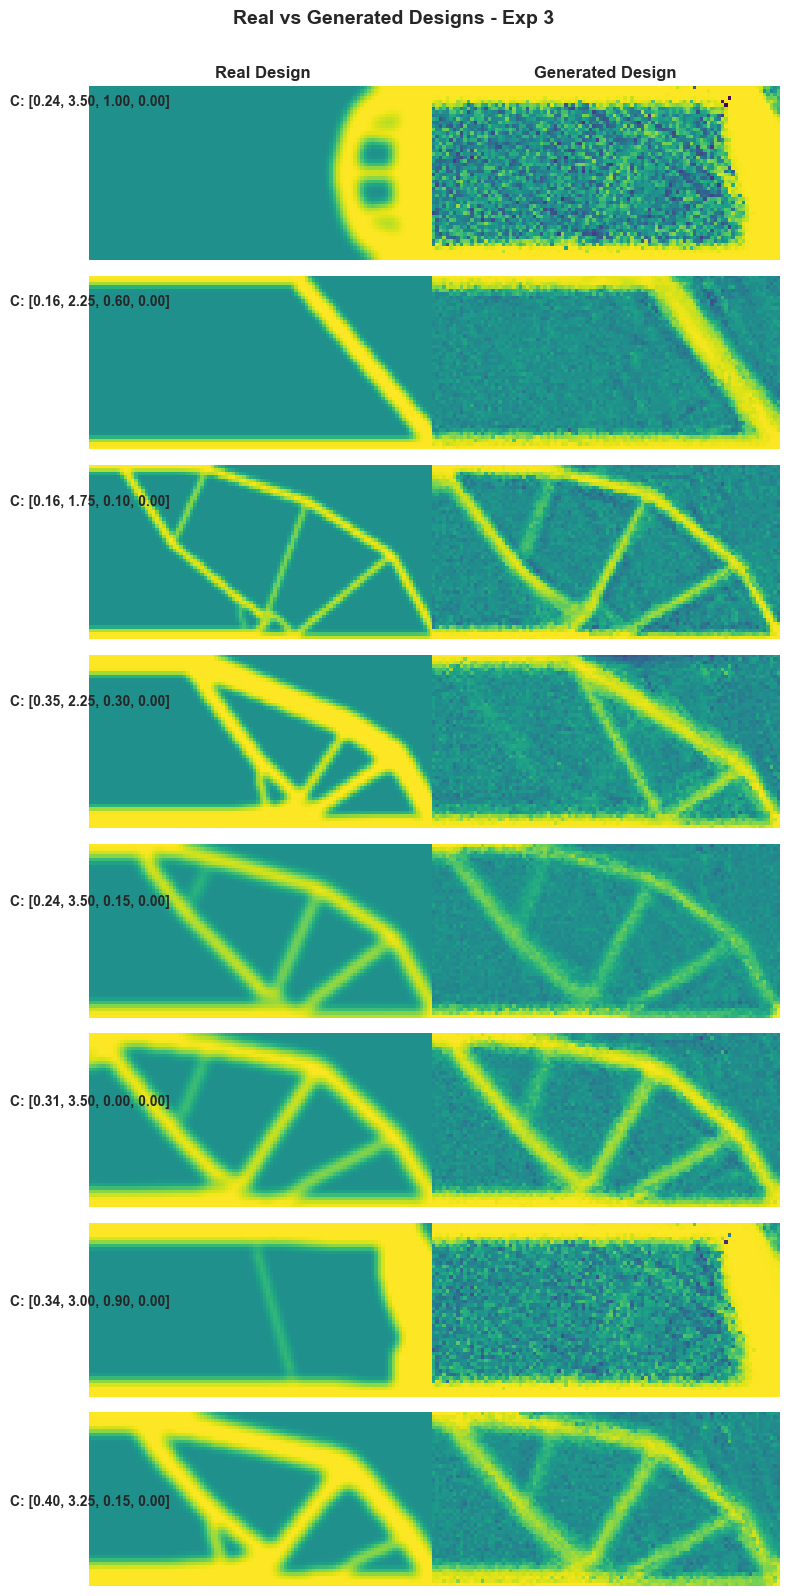

In [ ]:
print("\n" + "="*80)
print("EXPERIMENT 3: Balanced Training")
print("Settings: lr_gen=1e-4, lr_disc=4e-4 (standard 1:4 ratio)")
print("="*80 + "\n")

latent_dim = 100

gen_exp3, disc_exp3, hist_exp3 = train_cgan(
    problem_id="beams2d",
    n_epochs=100,
    batch_size=32,
    latent_dim=latent_dim,
    lr_gen=1e-4,
    lr_disc=4e-4,
    seed=42,
    snapshot_interval=10,
    print_every=20,
    spectral_norm=False
)

plot_training_diagnostics(hist_exp3, " - Exp 3")
plot_generated_vs_real_designs(gen_exp3, latent_dim, n_conds, design_shape, " - Exp 3")